In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib
import warnings
warnings.filterwarnings('ignore')

from qreservoirpy import util
from qreservoirpy.reservoirs import Static
from qreservoirpy.plot import state_plotter

from qiskit_aer import AerSimulator
backend = AerSimulator(method="stabilizer")

from qiskit.circuit.library.standard_gates import HGate, SGate, CXGate



## Initialization

In [24]:
n_qubits = 4
SHOTS = 10000
timeseries = [0, 1, 1, 2, 1, 1, 2] * 5
encoder = {
    0: '00',
    1: '01',
    2: '10',
    3: '11'
} 

circop = util.random_circuit(n_qubits, gates=[
    HGate, SGate, CXGate#, TGate
], depth=40)

OP = circop.to_gate(label='RES')
class RandomClifford(Static):
    def before(self, circuit):
        circuit.h(circuit.qubits)

    # What to do every timestep
    def during(self, circuit, timestep):
        circuit.measure(range(2))
        circuit.initialize(encoder[timestep], range(2))
        circuit.append(OP, circuit.qubits)





In [25]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
models = np.array([
    SVC(kernel=ker, max_iter=1000) for ker in ['linear', 'poly', 'rbf', 'sigmoid']
] 
+ [
    RidgeClassifier(alpha=alph, max_iter=1000) for alph in np.linspace(0, 1e-3, 9)
] 
+ [
    KNeighborsClassifier(n_neighbors=n) for n in range(1, 10)
]
, dtype=object)



In [26]:

    

qres = RandomClifford(n_qubits=n_qubits)
# fig = qres.circuit.draw('mpl')
# tikzplotlib.save("data/circuit_clifford.tex")


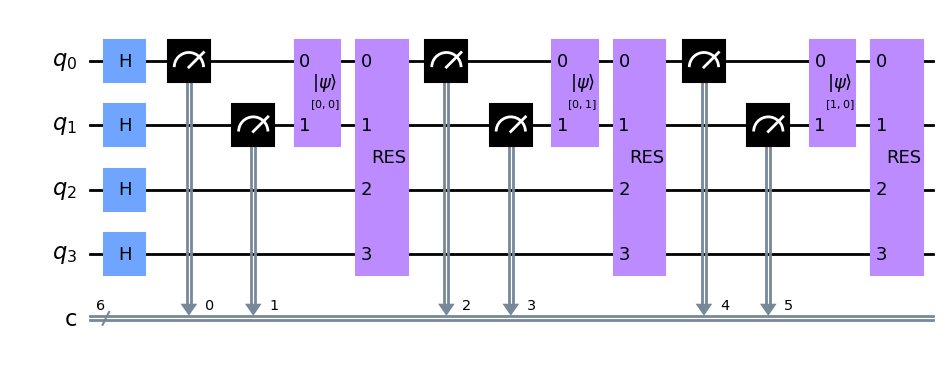

In [27]:
qres.circuit([0, 1, 2], merge_registers=True, transpile=False).draw('mpl')

## Running

In [28]:
states = qres.run(
    timeseries=timeseries, 
    shots=SHOTS,
    transpile=True
)


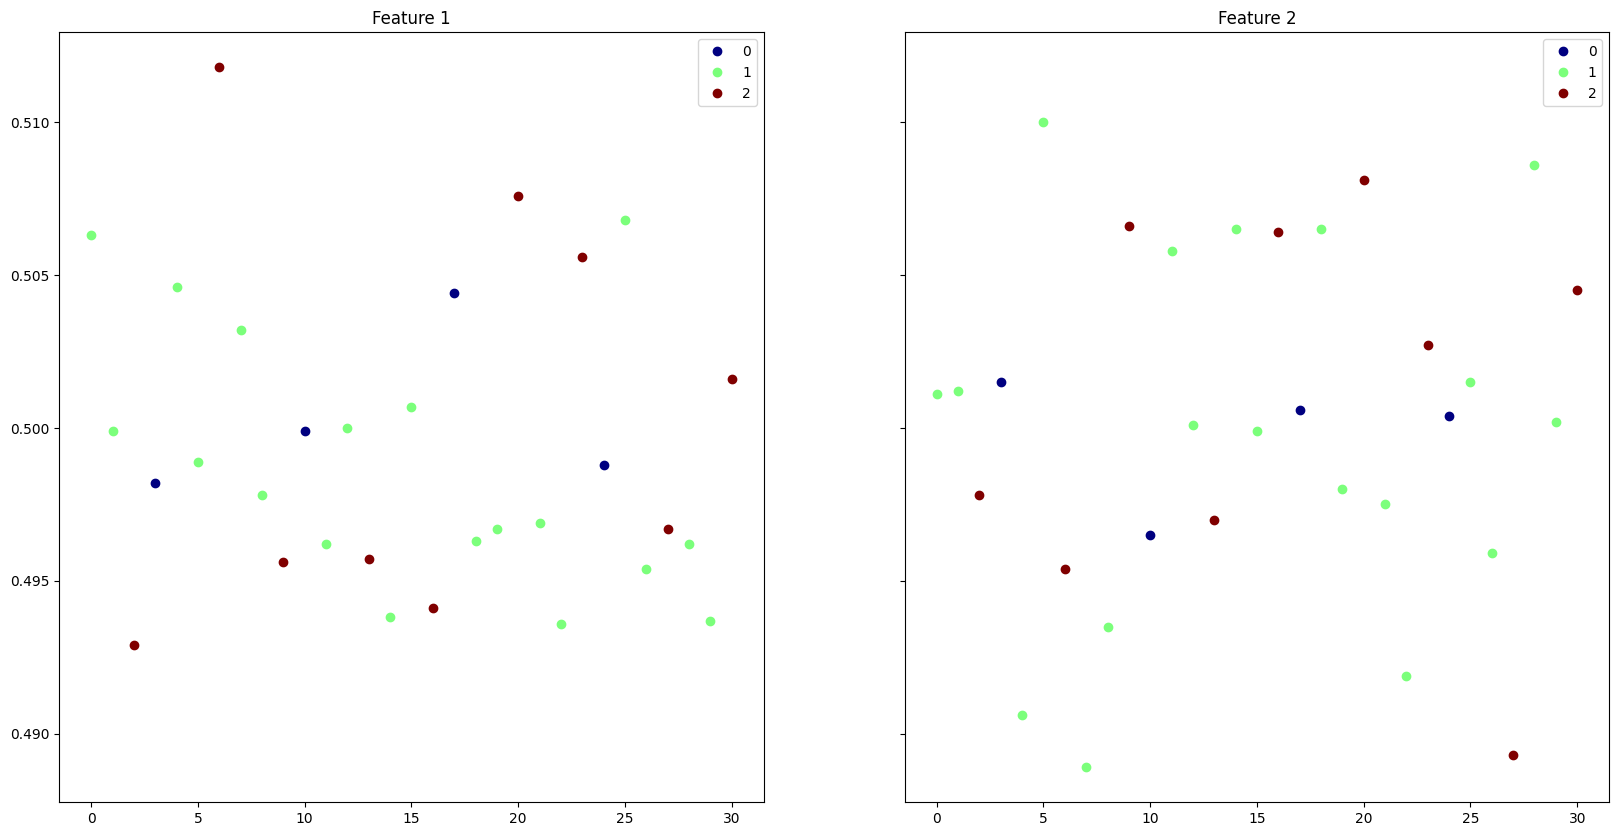

In [29]:
WARMUP = 0.1 # 10%
warmup_idx = int(len(states) * WARMUP)

xstates = states[:-1][warmup_idx:]
target = timeseries[1:][warmup_idx:]
fig, ax = state_plotter(xstates, target)

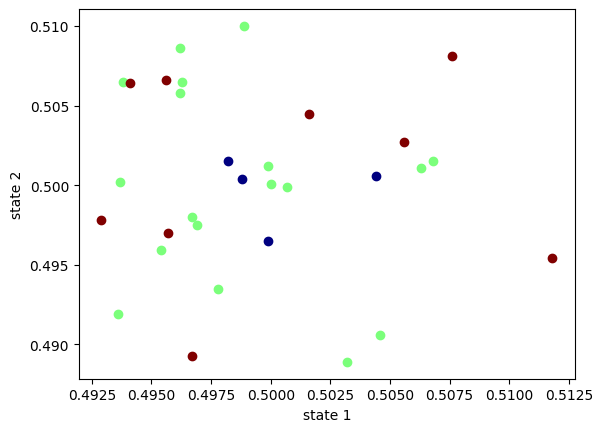

In [30]:
for ii in range(xstates.shape[-1] // 2):

    fig = plt.figure()
    ax = fig.add_subplot()

    cmap = plt.get_cmap('jet', len(np.unique(timeseries)))
    for i, x, y in zip(target, xstates[:, 2 * ii], xstates[:, 2 * ii + 1]):
        ax.scatter(x, y,  color=cmap(i))
    
    ax.set_xlabel(f'state {2 * ii + 1}')
    ax.set_ylabel(f'state {2*(ii+1)}')

# plt.show()


Text(0, 0.5, 'state 2')

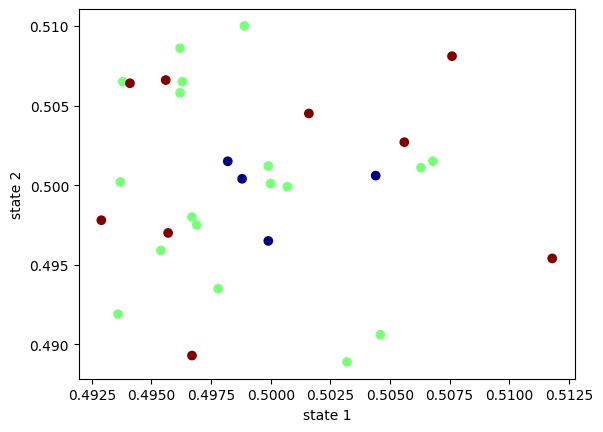

In [31]:



cmap = plt.get_cmap('jet', len(np.unique(timeseries)))

plt.scatter(xstates[:, 0], xstates[:, 1], cmap=cmap, c=target)
# for i, x, y in zip(target, xstates[:, 2 * ii], xstates[:, 2 * ii + 1]):
#     ax.scatter(x, y,  color=cmap(i))

# ax.set_xlabel(f'state {2 * ii + 1}')
# ax.set_ylabel(f'state {2*(ii+1)}')
plt.xlabel("state 1")
plt.ylabel("state 2")
# tikzplotlib.save("data/phase_clifford.tex")
# plt.show()


In [32]:
if xstates.shape[-1] >= 3:

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    cmap = plt.get_cmap('jet', len(np.unique(timeseries)))
    for i, x, y, z in zip(target, xstates[:, 0], xstates[:, 1], xstates[:, 2]):
        ax.scatter(x, y, z, color=cmap(i))
    ax.set_xlabel('state 1')
    ax.set_ylabel('state 2')
    ax.set_zlabel('state 3')

## Training

In [33]:


results = util.stress_test_models(xstates, target, models, test_to_train_ratio=1/3)
sorting = np.flip(np.argsort(results))
for model, res in zip(models[sorting], results[sorting]):
    print(f'Score of {model}: {res}')
    

model = models[sorting][0]


Score of SVC(kernel='linear', max_iter=1000): 0.5645454545454546
Score of SVC(kernel='sigmoid', max_iter=1000): 0.56
Score of RidgeClassifier(alpha=0.000875, max_iter=1000): 0.5509090909090911
Score of RidgeClassifier(alpha=0.001, max_iter=1000): 0.5500000000000002
Score of RidgeClassifier(alpha=0.00075, max_iter=1000): 0.5463636363636365
Score of RidgeClassifier(alpha=0.000625, max_iter=1000): 0.5400000000000003
Score of RidgeClassifier(alpha=0.0005, max_iter=1000): 0.5381818181818183
Score of RidgeClassifier(alpha=0.000375, max_iter=1000): 0.5318181818181819
Score of RidgeClassifier(alpha=0.00025, max_iter=1000): 0.5190909090909094
Score of RidgeClassifier(alpha=0.000125, max_iter=1000): 0.5072727272727277
Score of SVC(max_iter=1000): 0.5072727272727274
Score of KNeighborsClassifier(n_neighbors=9): 0.49272727272727296
Score of RidgeClassifier(alpha=0.0, max_iter=1000): 0.4927272727272729
Score of KNeighborsClassifier(n_neighbors=8): 0.48000000000000015
Score of KNeighborsClassifier(n

## Predicting

In [34]:
predict_from = timeseries[-20:]
num_preds = 10


preds = qres.predict(
    num_pred=num_preds,
    model=model,
    shots=SHOTS,
    from_series=predict_from,
)


Predicting...: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]


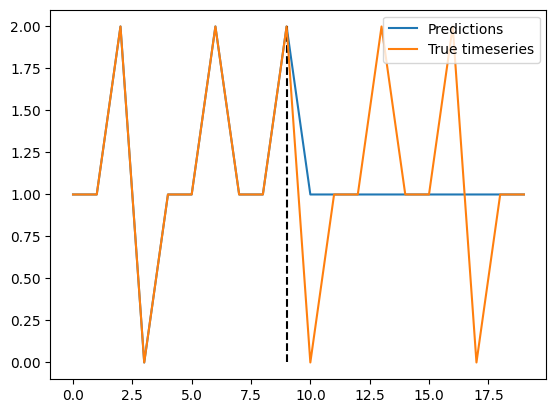

In [35]:
true_values = timeseries

pred_plot = np.append(predict_from[-num_preds:], preds)
true_plot = np.append(predict_from[-num_preds:], true_values)

minlen = min(len(pred_plot), len(true_plot))

plt.plot(pred_plot[:minlen], label="Predictions")
plt.vlines(num_preds - 1, ymin=np.min(target), ymax=np.max(target), colors='k', linestyles='dashed')
plt.plot(true_plot[:minlen], label="True timeseries")
plt.legend()

In [15]:
assert(0 == 1)
NUM_EXP = 1000
exp_res = np.zeros((NUM_EXP, len(models)))

for i in tqdm(range(NUM_EXP), desc="Experiment"):
    circop = utilities.random_circuit(n_qubits, gates=[
        HGate, SGate, CXGate#, TGate
    ], depth=40)

    OP = circop.to_gate(label='RES')
    qres = QReservoir(qubits=n_qubits, layers=[
    Layers.Reset(),
    Layers.Timeseries(build_method=build_method, 
                      encoding = encoder,
                      reservoir = OP)
    ])

    states = qres.run(
        timeseries=timeseries, 
        shots=SHOTS,
        transpile=True,
    )

    xstates = states[:-1][warmup_idx:]
    target = timeseries[1:][warmup_idx:]
    exp_res[i] = utilities.stress_test_models(xstates, target, models, test_to_train_ratio=1/3, N=50)




Experiment: 100%|██████████| 1000/1000 [2:20:01<00:00,  8.40s/it] 


In [16]:
# np.save("data/clifford_LONGSIM", exp_res)

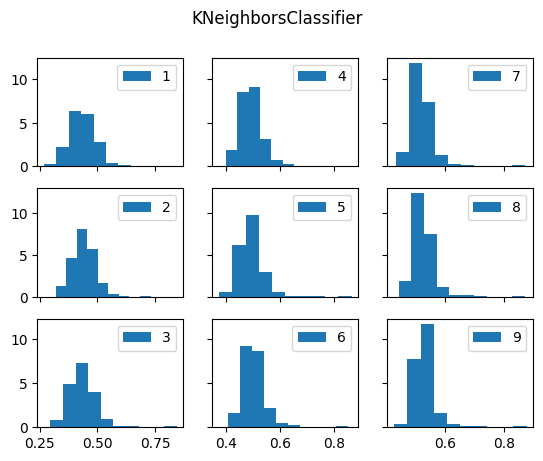

In [17]:

fig, axes = plt.subplots(ncols=3, nrows=3, sharex='col', sharey='row')
fig.suptitle("KNeighborsClassifier")
ii = 0
jj = 0

mod = KNeighborsClassifier(n_neighbors=2)
for idx, model in enumerate(models):
    if type(model) == KNeighborsClassifier:
        axes[ii][jj].hist(exp_res[:, idx], density=True)
        axes[ii][jj].legend([model.n_neighbors])
        ii += 1
        if ii >= len(axes):
            ii = 0
            jj += 1
# temp_res = exp_res[:, 0]
# _ = axes.hist(temp_res)



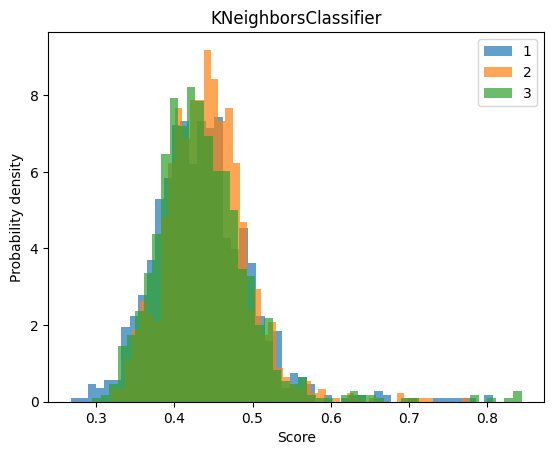

In [18]:

plt.figure()
plt.title("KNeighborsClassifier")
for idx, model in enumerate(models):
    if type(model) == KNeighborsClassifier and model.n_neighbors in range(1, 4):
        # plt.xlim([0.5, 1])
        plt.hist(exp_res[:, idx], density=True, label=model.n_neighbors, alpha=0.7, bins=50)
        ii += 1
        if ii >= len(axes):
            ii = 0
            jj += 1
plt.legend()
plt.xlabel("Score")
plt.ylabel("Probability density")
# tikzplotlib.save("data/clifford_KNeighbors.tex")


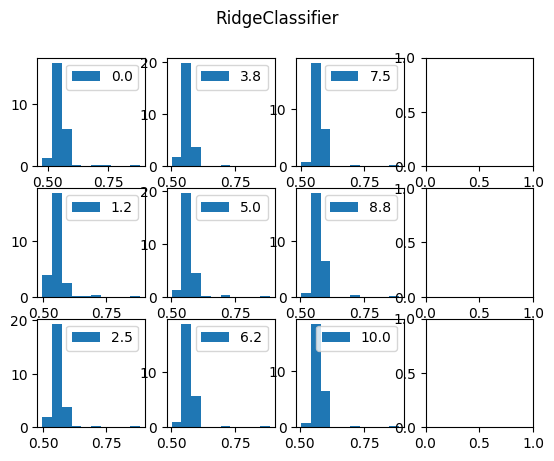

In [19]:
fig, axes = plt.subplots(ncols=4, nrows=3)
fig.suptitle("RidgeClassifier")
ii = 0
jj = 0

for idx, model in enumerate(models):
    if type(model) == RidgeClassifier:
        # axes[ii][jj].set_xlim([0, 1])
        axes[ii][jj].hist(exp_res[:, idx], density=True)
        axes[ii][jj].legend([round(model.alpha * 1e4, 1)])
        ii += 1
        if ii >= len(axes):
            ii = 0
            jj += 1

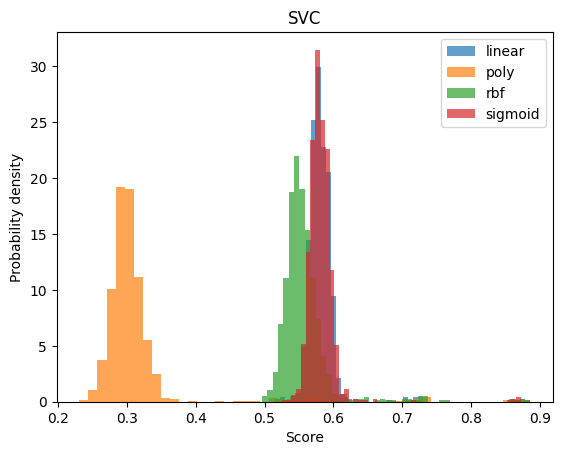

In [20]:
# fig, axes = plt.subplots(ncols=2, nrows=2)
# fig.suptitle("SVC")
# ii = 0
# jj = 0
plt.figure()
plt.title("SVC")
# plt.xlim([0, 1])

for idx, model in enumerate(models):
    if type(model) == SVC:
        # plt.xlim([0.5, 1])
        plt.hist(exp_res[:, idx], density=True, label=model.kernel, alpha=0.7, bins=50)
        ii += 1
        if ii >= len(axes):
            ii = 0
            jj += 1
plt.legend()
plt.xlabel("Score")
plt.ylabel("Probability density")
# tikzplotlib.save("data/clifford_SVC.tex")


Text(0.5, 0, 'Score')

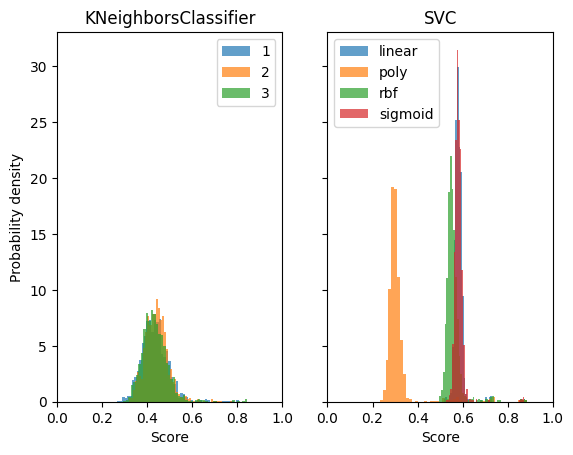

In [22]:
fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True)

ax[0].set_title("KNeighborsClassifier")
for idx, model in enumerate(models):
    if type(model) == KNeighborsClassifier and model.n_neighbors in [1, 2, 3]:
        ax[0].set_xlim([0, 1])
        ax[0].hist(exp_res[:, idx], density=True, label=model.n_neighbors, alpha=0.7, bins=50)
        ii += 1
        if ii >= len(axes):
            ii = 0
            jj += 1

ax[0].legend()
ax[0].set_xlabel("Score")
ax[0].set_ylabel("Probability density")

ax[1].set_title("SVC")

for idx, model in enumerate(models):
    if type(model) == SVC:
        ax[1].set_xlim([0, 1])
        ax[1].hist(exp_res[:, idx], density=True, label=model.kernel, alpha=0.7, bins=50)
        ii += 1
        if ii >= len(axes):
            ii = 0
            jj += 1
ax[1].legend()
ax[1].set_xlabel("Score")

# tikzplotlib.save("data/clifford_BOTH.tex")
